## Imports

In [87]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import shap
import seaborn as sns

## Input info

In [3]:
entity_flavor_molecules_name_reduced = pd.read_pickle("../data/interim/efm.pkl")
entity_flavor_profile_reduced = pd.read_pickle("../data/interim/efp.pkl")
entity_functional_group_reduced = pd.read_pickle("../data/interim/efg.pkl")
entity_nutrition_facts = pd.read_pickle("../data/interim/enf.pkl")

In [4]:
base_ingredients = pd.read_pickle('../data/interim/available_ingredients.pkl')
base_ingredients = pd.Series(base_ingredients.index)

model = pd.read_pickle('../models/first_model.pkl')
model = pd.read_pickle('../models/model.pkl')

In [5]:
# explainer
explainer = shap.TreeExplainer(model)

## Functions

In [6]:
def get_features_vector(ingredient_list):
    return pd.concat([
        entity_flavor_molecules_name_reduced.loc[ingredient_list].mean(), 
        entity_flavor_profile_reduced.loc[ingredient_list].mean(), 
        entity_functional_group_reduced.loc[ingredient_list].mean(),
        entity_nutrition_facts.loc[ingredient_list].mean()
    ])

In [8]:
def get_score(x_vals):
    result = model.predict_proba(x_vals)[:,1]
    return result

In [9]:
def get_ingredient_list_from_length(length, undesired_ingredients=[]):
    ingredient_list = base_ingredients[~(base_ingredients.isin(undesired_ingredients))].sample(length).to_list()
    return ingredient_list

# Model use

In [29]:
product_1 = ['Yogurt' ]
product_2 = [
  'Loquat',
  'Strawberry',
  'Syrup',
  'Sugar',
  #'Milk',
  'Barley',
  'Wild boar']

product_1, product_2 = ['Asparagus', 'Salt', 'Water'], ['Beans', 'Carrot', 'Corn', 'Green Beans', 'Peas']


product_1_features = get_features_vector(product_1)
product_2_features = get_features_vector(product_2)

x_vals = make_features_model_consumable_forSeries(product_1_features, product_2_features)
get_score(x_vals)

array([0.39538462])

In [31]:
    max_display = 20
    shap_values = explainer.shap_values(x_vals)[1]
    processed_shap_values = pd.DataFrame(shap_values, columns=x_vals.columns).abs().T.sort_values(0, ascending=False)
    processed_shap_values['shap_vals'] = pd.DataFrame(shap_values, columns=x_vals.columns).T.loc[processed_shap_values.index][0]


In [59]:
    top_features = pd.Series(processed_shap_values.head(50).index)


In [60]:
processed_shap_values

,0,shap_vals
ENERC_KCAL_x,1.325584e-02,1.325584e-02
PROCNT_x,9.958655e-03,9.958655e-03
flavor_profile__46_x,9.852024e-03,9.852024e-03
functional_group__13_x,8.961884e-03,8.961884e-03
NA_x,7.543008e-03,7.543008e-03
...,...,...
functional_group__10_x,4.939649e-06,4.939649e-06
common_name__40_y,4.842763e-06,4.842763e-06
common_name__71_x,3.262378e-06,3.262378e-06
common_name__28_x,2.148535e-06,-2.148535e-06


In [66]:
relevant_features = top_features.str.split('__').apply(lambda x: x[0])
condition__flavor_profile = relevant_features.str.startswith('flavor_profile')
condition__common_name = relevant_features.str.startswith('common_name')
condition__functional_group = relevant_features.str.startswith('functional_group')
condition__nutrients = ~(condition__flavor_profile|condition__common_name|condition__functional_group)
relevant_features_df = pd.DataFrame(relevant_features)
relevant_features_df.loc[condition__flavor_profile, 'tag'] = 'flavor_profile'
relevant_features_df.loc[condition__common_name, 'tag'] = 'common_name'
relevant_features_df.loc[condition__functional_group, 'tag'] = 'functional_group'
relevant_features_df.loc[condition__nutrients, 'tag'] = 'nutrients'
relevant_datasets = relevant_features_df.tag.value_counts(normalize=True)

processed_shap_values = processed_shap_values.head(max_display)
processed_shap_values.loc[processed_shap_values.shap_vals > 0, 'color'] = 'deeppink'
processed_shap_values.loc[processed_shap_values.shap_vals <= 0, 'color'] = 'dodgerblue'


In [70]:
    plt.figure()
    plt.subplot(121)
    
    sns.barplot(y=processed_shap_values.index, x=processed_shap_values.shap_vals, palette=processed_shap_values.color, orient='h')
    plt.box(False)
    plt.xlabel('Valores Shap')
    plt.ylabel('Características más relevantes')
    plt.subplot(122)
    pie_results = relevant_datasets.to_dict()
    datasets_colors = {'nutrition': 'seagreen', 'flavor': 'lightsalmon', 'molecule_name': 'crimson', 'profile': 'slateblue'}
    colors=[datasets_colors.get(key) for key in pie_results.keys()]
    plt.pie(x=pie_results.values(), labels=pie_results.keys(), startangle=90, autopct='%1.1f%%', colors=colors)
    plt.show()


<Figure size 640x480 with 2 Axes>

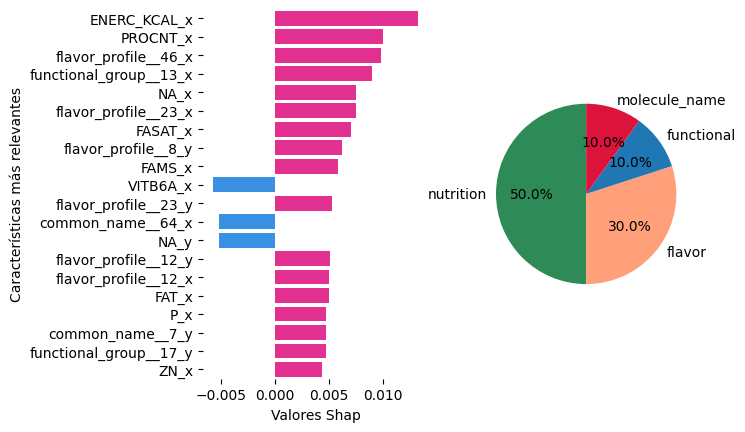

In [10]:
    max_display = 20
    shap_values = explainer.shap_values(x_vals)[1]
    
    processed_shap_values = pd.DataFrame(shap_values, columns=x_vals.columns).abs().T.sort_values(0, ascending=False)
    processed_shap_values['shap_vals'] = pd.DataFrame(shap_values, columns=x_vals.columns).T.loc[processed_shap_values.index][0]

    top_features = pd.Series(processed_shap_values.head(max_display).index)
    x_or_y = top_features.str.split('_').apply(lambda x: x[-1]).value_counts(normalize=True)
    nutrition_features = pd.Series(entity_nutrition_facts.columns).str.split('_').apply(lambda x:x[0]).to_list()

    relevant_features = top_features.str.split('_').apply(lambda x: x[0])
    relevant_features.loc[relevant_features.isin(nutrition_features)] = 'nutrition'
    relevant_features.loc[relevant_features=='common'] = 'molecule_name'
    relevant_datasets = relevant_features.value_counts(normalize=True)

    relevant_features2 = relevant_features +'_' + relevant_features.str.split('_').apply(lambda x: x[-1])
    relevant_datasets_x_or_y =  relevant_features2.value_counts(normalize=True)

    processed_shap_values = processed_shap_values.head(max_display)
    processed_shap_values.loc[processed_shap_values.shap_vals > 0, 'color'] = 'deeppink'
    processed_shap_values.loc[processed_shap_values.shap_vals <= 0, 'color'] = 'dodgerblue'
    plt.subplot(121)
    sns.barplot(y=processed_shap_values.index, x=processed_shap_values.shap_vals, palette=processed_shap_values.color, orient='h')
    plt.box(False)
    plt.xlabel('Valores Shap')
    plt.ylabel('Características más relevantes')
    plt.subplot(122)
    pie_results = relevant_datasets.to_dict()
    datasets_colors = {'nutrition': 'indianred', 'flavor': 'steelblue', 'molecule_name': 'turquoise', 'profile': 'lightblue'}
    colors=[datasets_colors.get(key) for key in pie_results.keys()]
    plt.pie(x=pie_results.values(), labels=pie_results.keys(), startangle=90, autopct='%1.1f%%', colors=colors)
    plt.show()


In [89]:
#pip install gradio
COLOR = '#FBFBF9'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR


In [17]:
import gradio as gr

def product_comparison(product_a, product_b):
    product_a_features = get_features_vector(product_a)
    product_b_features = get_features_vector(product_b)
    x_vals = make_features_model_consumable_forSeries(product_a_features, product_b_features)
    return get_score(x_vals)[0], 

def product_comparison(product_a, product_b):
    product_a_features = get_features_vector(product_a)
    product_b_features = get_features_vector(product_b)
    x_vals = make_features_model_consumable_forSeries(product_a_features, product_b_features)
    
    fig = get_explanations(x_vals)
    
    return get_score(x_vals)[0], fig

ingredient_list = base_ingredients.to_list()

In [102]:
def get_explanations(x_vals): 
    max_display = 20
    shap_values = explainer.shap_values(x_vals)[1]
    
    processed_shap_values = pd.DataFrame(shap_values, columns=x_vals.columns).abs().T.sort_values(0, ascending=False)
    processed_shap_values['shap_vals'] = pd.DataFrame(shap_values, columns=x_vals.columns).T.loc[processed_shap_values.index][0]

    top_features = pd.Series(processed_shap_values.head(max_display).index)
    x_or_y = top_features.str.split('_').apply(lambda x: x[-1]).value_counts(normalize=True)
    nutrition_features = pd.Series(entity_nutrition_facts.columns).str.split('_').apply(lambda x:x[0]).to_list()

    relevant_features = top_features.str.split('_').apply(lambda x: x[0])
    relevant_features.loc[relevant_features.isin(nutrition_features)] = 'nutrition'
    relevant_features.loc[relevant_features=='common'] = 'molecule_name'
    relevant_datasets = relevant_features.value_counts(normalize=True)

    relevant_features2 = relevant_features +'_' + relevant_features.str.split('_').apply(lambda x: x[-1])
    relevant_datasets_x_or_y =  relevant_features2.value_counts(normalize=True)

    processed_shap_values = processed_shap_values.head(max_display)
    processed_shap_values.loc[processed_shap_values.shap_vals > 0, 'color'] = 'deeppink'
    processed_shap_values.loc[processed_shap_values.shap_vals <= 0, 'color'] = 'dodgerblue'
    
    fig = plt.figure(facecolor='#1f2937')
    plt.suptitle('Product Explanations')
    plt.subplot(121)
    plt.title('Shap importance')
    sns.barplot(y=processed_shap_values.index, x=processed_shap_values.shap_vals, palette=processed_shap_values.color, orient='h')
    plt.box(False)
    plt.xlabel('Shap Values',)
    plt.ylabel('Most relevant features')
    plt.subplot(122)
    plt.title('General relevance')
    pie_results = relevant_datasets.to_dict()
    datasets_colors = {'nutrition': 'indianred', 'flavor': 'steelblue', 'molecule_name': 'cadetblue', 'profile': 'lightblue'}
    colors=[datasets_colors.get(key) for key in pie_results.keys()]
    plt.pie(x=pie_results.values(), labels=pie_results.keys(), startangle=90, autopct='%1.1f%%', colors=colors)
    plt.tight_layout()
    return fig

product_description = "Please, enter the ingredients as a list of values. You can select more than one ingredient."
general_description = 'Add the list of ingredients of "Product X" and "Product Y" in the corrponding fields, then click "Submit". The model will compare them and obtain a coeficient that goes from 0 to 1, where 1 means that the products are indeed similar. And 0 means they are definitely not similar.  '

demo = gr.Interface(
    product_comparison,
    [
        gr.Dropdown(
            ingredient_list, 
            value=['Asparagus', 'Salt', 'Water'],
            multiselect=True, 
            label="Product X", 
            info=product_description
        ),
        gr.Dropdown(
            ingredient_list,
            value=['Beans', 'Carrot', 'Corn', 'Green Beans', 'Peas'],
            multiselect=True, 
            label="Product Y", 
            info=product_description
        ),
    ],
    [gr.Text(label='Model Score'), gr.Plot(label="Explanation")],
    examples=[
        [['Asparagus', 'Salt', 'Water'],['Beans', 'Carrot', 'Corn', 'Green Beans', 'Peas']],
        [['Amaranth', 'Banana', 'Chia', 'Flour', 'Kale', 'Lemon', 'Milk', 'Oats', 'Strawberry', 'Water', 'Yogurt'], ['Beans', 'Coconut', 'Cream', 'Milk', 'Pectin', 'Sugar']],
        [['Crab', 'Salt'], ['Salt', 'Shrimp']],
        [['Anchovy', 'Olive', 'Salt'], ['Salmon', 'Salt', 'Sockeye salmon']],
        [['Salmon', 'Salt', 'Sockeye salmon'],['Anchovy', 'Olive', 'Salt']],
        [['Barley', 'Lentils', 'Malt', 'Millet', 'Salt', 'Soybean', 'Spelt', 'Water', 'Wheat'], ['Barley', 'Buttermilk', 'Cream', 'Flour', 'Garlic', 'Malt', 'Onion', 'Salt', 'Soybean', 'Soybean Oil', 'Spread', 'Sugar', 'Water', 'Wheat']],

    ],
    title='Model Product Comparison',
    
    description = general_description,
)

if __name__ == "__main__":
    demo.launch(share=True, debug=True)
    #demo.close()

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Keyboard interruption in main thread... closing server.


# TODO:

- Include all trivial cases to the model: Same Ingredient list in productA and productB cases should have a score similarity of 1 in train.
- Is it that what we have is the best way to represent a product, or should something else be used as "embedding".
- Improve genetic algorithm (make it a more accurate genetic algorithm).
- How can we improve the following case?: ProductA + ProductB should be the same as ProductB + ProductA.
- Make more robust filters when comparing products. (There is some trash when a food is not completely captured).
- Include the additives as features (take in cosideration the application of this of the producton model and the genetic algorithm).
- Generate product instances (lists) with genetic algorithm with a good threshold.
- Generate an app that automatically generates lists. 
- Upload data somewhere, so it can be retrieved by all the team members.
- Upload to github, so code can be reviewed by all team members.
